<a href="https://colab.research.google.com/github/mkorlyakova/MSTU-courses/blob/main/ML%20magister/1/Lec_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Классификация с помощью kNN

## Меры и метрики расстояния между объектами

Понятие метрических пространств, метрик и некоторые их примеры уже рассматривались вами на курсе по линейной алгебре в рамках обучения по профессии. В этом разделе мы вспомним, какие могут быть метрики и их применение в плоскости машинного обучения.

Метрика является функцией, задающей расстояние в метрическом пространстве. Как мы помним из курса линейной алгебры, она должна удовлетворять трем аксиомам:

1. $\rho(x, y) \geq 0, \rho(x, y) = 0 \Leftrightarrow x = y;$
2. $\rho(x, y) = \rho (y, x);$
3. $\rho(x, y) \leq \rho(x, z) + \rho(z, y).$

Евклидова метрика

$$\rho(x, y) = \sqrt{\sum_{i=1}^{n}(x_{i}-y_{i})^{2}}$$

и манхэттенская метрика

$$\rho(x, y) = \sum_{i=1}^{n}|x_{i}-y_{i}|$$

уже должны быть вам знакомы. 

Также можно показать обобщение этих двух метрик - метрика Минковского:

$$\rho(x, y) = \left ( \sum_{i=1}^{n}|x_{i}-y_{i}|^{q} \right )^{\frac{1}{q}}.$$

При этом при $q = 1$ получаем манхэттенскую ($L_{1}$) метрику, при $q = 2$ - евклидову ($L_{2}$) метрику.

Кроме этого, в метрических алгоритмах часто используются так называемые меры близости. В отличие от метрик, которые тем меньше, чем объекты более похожи, меры близости увеличиваются при увеличении похожести (близости) объектов.

Примером такой функции может быть _косинусное сходство (косинусная мера)_:

$$\text{cos}\theta = \frac{\left \langle x, y \right \rangle}{||x||\cdot||y||} = \frac{\sum_{i=1}^{n}x_{i}y_{i}}{\sqrt{\sum_{i=1}^{n}x_{i}^{2}}\sqrt{\sum_{i=1}^{n}y_{i}^{2}}}.$$

Из этой функции также вытекает _косинусное расстояние_:

$$\rho_{cos}(x, y) = 1 - \text{cos}\theta = 1 - \frac{\sum_{i=1}^{n}x_{i}y_{i}}{\sqrt{\sum_{i=1}^{n}x_{i}^{2}}\sqrt{\sum_{i=1}^{n}y_{i}^{2}}}.$$

__Аналитический смысл__: объекты представлены в виде векторов, между двумя векторами образуется угол, значение косинуса этого угла – это и есть косинусная мера (следует из формулы скалярного произведения). 

__Почему эта функция - метрика?__

* f(x, x) = 0 - потому что arccos(1)=0
* f(x,y) = f(y,x) - по симметрии - очевидно, что угол между x и y равен углу между y и x
* f(x,y) >= 0 - потому что мы рассматриваем углы от 0 до 180 градусов
* неравенство треугольника (физический смысл)

Именно такая формула используется в функции `scipy.spatial.distance.cosine()` из библиотеки scipy, возвращающая косинусное расстояние между двумя векторами.

Косинусная мера часто используется в анализе текстов.

Кроме косинусной меры в прикладных задачах могут использоваться и другие функции - коэффициент Дайса, коэффициент Жаккара, коэффициент перекрытия (см. доп. материалы).

Формула нахождения косинусной меры похожа на _коэффициент корреляции_, который также может быть использован как мера близости и используется обычно в рекомендательных системах:

$$r = \frac{\sum_{i=1}^{n}((x_{i} - \bar{x})(y_{i} - \bar{y}))}{\sqrt{\sum_{i=1}^{n}(x_{i} - \bar{x})^{2}}\sqrt{\sum_{i=1}^{n}(y_{i} - \bar{y})^{2}}}$$

In [ ]:
import numpy as np
from sklearn import model_selection
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
from matplotlib.colors import ListedColormap

In [ ]:
# расстояние минковского (р=2 - эвклид, р=1 - квартальное)
def dist_mincovski(X1,X2,p):
    if p != 0:
        return np.sum(np.abs(X1-X2)** p) ** 1/p
    else: return 1

def dist_cos(X1,X2):
    
    return 1 - (np.dot(X1.reshape(1,-1), X2.reshape(-1,1)))/np.sum(X1 ** 2)/ np.sum(X2 ** 2)



C:\Users\1\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


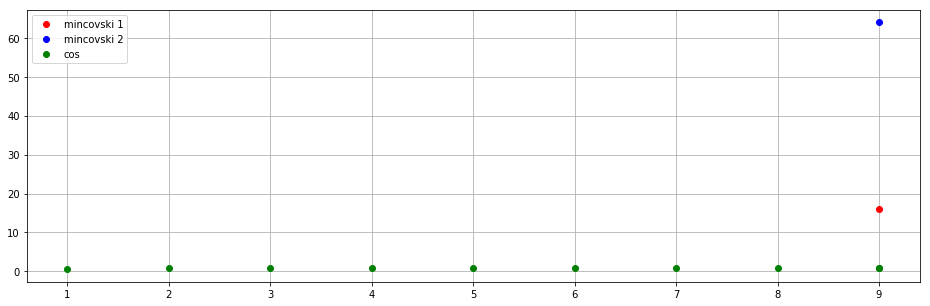

In [ ]:
X1 = np.array([1,1])
plt.figure(figsize = (16,5))
               
               
for xi in range(10):
    X2 = np.array([xi,xi])
    r1 = dist_mincovski(X1,X2,1)
    r2 = dist_mincovski(X1,X2,2)
    rc = dist_cos(X1,X2)
    
    #plt.plot(xi,r1,'or')
    #plt.plot(xi,r2,'ob')
    plt.plot(xi,rc,'og')
    
    
#
plt.plot(xi,r1,'or', label = 'mincovski 1')
#
plt.plot(xi,r2,'ob', label = 'mincovski 2')
plt.plot(xi,rc,'og', label = 'cos')   
plt.legend()
plt.grid(True)
plt.show()
    

## Алгоритм kNN

Начнем обсуждение метрических алгоритмов с алгоритма kNN. Данный алгоритм является еще одним способом решения задачи классификации. Расшифровывается его название как "k ближайших соседей (k nearest neighbours)".

Суть его довольно проста и заключается в принципе отнесения объекту к тому классу, представители которого преобладают рядом с ним. Таким образом, упрощенно алгоритм классификации выглядит следующим образом:

- найти расстояние от объекта $u$ до каждого из объектов $x$ обучающей выборки;
- выбрать $k$ объектов, расстояние до которых минимально;
- отнести объект к классу, к которому относится большинство из выбранных $k$ ближайших соседей:

$$a(u) = \underset{y}{\text{argmax}}\sum_{i=1}^{k}[y_{u}^{(i)}=y],$$

то есть провести голосование.

При этом метод можно адаптировать под регрессию: в этом случае находится не метка класса, а среднее значение ответа среди $k$ соседей.

Интересной особенностью метода является то, что __на этапе обучения не строится модель__, а просто запоминается обучающая выборка. Вычисления начинаются именно на этапе решения задачи классификации конкретного объекта (поэтому этот алгоритм можно назвать ленивым).

Логичным усовершенствованием алгоритма kNN является добавление соседям весов (так называемое "взвешенное голосование"), зависящих от их порядкового номера или расстояния до классифицируемого объекта (чем ближе объект обучающей выборки, тем больше его вес).

От номера соседа $i$ веса можно определять как:

- $w(i) = q^{i}$,   $q \in (0,1)$;


- $w(i) = \frac{1}{i}$;


- $w(i) = \frac{1}{(i+a)^{b}}$;


- $w(i) = \frac{k + 1 - i}{k}$.


От расстояния $d$ веса можно определять как:

- $w(d) = q^{d}$,   $q \in (0,1)$;


- $w(d) = \frac{1}{(d+a)^{b}}$, брать вес $\frac{1}{d}$ по аналогии с номером соседа - неудачное решение, так как при $d = 0$ вес будет бесконечно большим, что приводит к переобучению


- $w(d) = \begin{cases}
\frac{d(z_{k}, x) - d(z_{i}, x)}{d(z_{k}, x) - d(z_{1}, x)}, & d(z_{k}, x) \neq d(z_{1}, x) \\ 
1, & d(z_{k}, x) = d(z_{1}, x)
\end{cases}$.

Существуют и другие способы вычисления весов.

Часто перед работой по алгоритму kNN требуется проводить нормализацию признаков, так как они могут иметь разные единицы измерения, что может искажать расстояние между объектами.

В общем и целом получается, что при работе с алгоритмом kNN исследователю требуется подобрать три параметра - количество соседей k, метрика расстояния и способ вычисления весов. Для получения лучшего качества работы алгоритма эти параметры нужно подбирать на отложенной выборке или при помощи кросс-валидации.

Реализуем алгоритм kNN с помощью Python.

Загрузим один из "игрушечных" датасетов из sklearn.

In [ ]:
X, y = load_iris(return_X_y=True)

# Для наглядности возьмем только первые два признака (всего в датасете их 4)
X = X[:, :2]

Разделим выборку на обучающую и тестовую

In [ ]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=1)

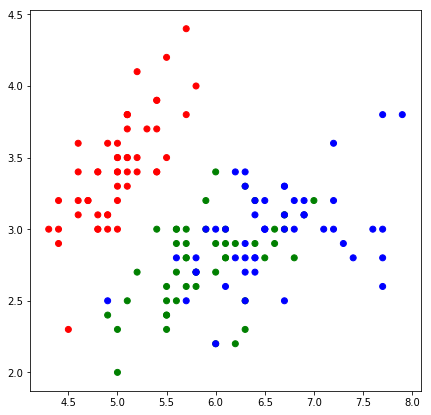

In [ ]:
cmap = ListedColormap(['red', 'green', 'blue'])
plt.figure(figsize=(7, 7))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap)

Используем евклидову метрику. Реализуем функцию для ее подсчета.

In [ ]:
def e_metrics(x1, x2):
    
    distance = 0
    for i in range(len(x1)):
        distance += np.square(x1[i] - x2[i])
        #distance += np.abs(x1[i] - x2[i])
    
    return np.sqrt(distance)
    #return (distance)

Реализуем алгоритм поиска k ближайших соседей.

In [ ]:
def knn(x_train, y_train, x_test, k):
    
    answers = []
    for x in x_test:
        test_distances = []
        #print(len(answers))    
        for i in range(len(x_train)):
            
            # расчет расстояния от классифицируемого объекта до
            # объекта обучающей выборки
            distance = e_metrics(x, x_train[i])
            
            # Записываем в список значение расстояния и ответа на объекте обучающей выборки
            test_distances.append((distance, y_train[i]))
        
        # создаем словарь со всеми возможными классами
        classes = {class_item: 0 for class_item in set(y_train)}
        
        # Сортируем список и среди первых k элементов подсчитаем частоту появления разных классов
        for d in sorted(test_distances)[0:k]:
            classes[d[1]] += 1
            
        # Записываем в список ответов наиболее часто встречающийся класс
        answers.append(sorted(classes, key=classes.get)[-1])
    return answers

Напишем функцию для вычисления точности

In [ ]:
def accuracy(pred, y):
    return (sum(pred == y) / len(y))

Проверим работу алгоритма при различных k

In [ ]:
k = 1

y_pred = knn(X_train, y_train, X_test, k)

print(f'Точность алгоритма при k = {k}: {accuracy(y_pred, y_test):.3f}')

Точность алгоритма при k = 1: 0.667


Построим график распределения классов.

In [ ]:
def get_graph(X_train, y_train, k):
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA','#00AAFF'])

    h = .2

    # Расчет пределов графика
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Получим предсказания для всех точек
    Z = knn(X_train, y_train, np.c_[xx.ravel(), yy.ravel()], k)

    # Построим график
    Z = np.array(Z).reshape(xx.shape)
    plt.figure(figsize=(7,7))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Добавим на график обучающую выборку
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(f"Трехклассовая kNN классификация при k = {k}")
    plt.show()

In [ ]:
X_train.shape

(120, 2)

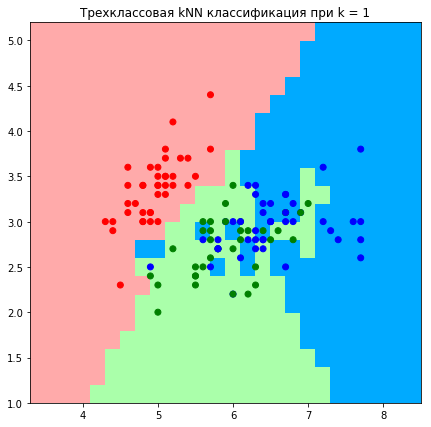

In [ ]:
get_graph(X_train, y_train, k)

In [ ]:
k = 3

y_pred = knn(X_train, y_train, X_test, k)

print(f'Точность алгоритма при k = {k}: {accuracy(y_pred, y_test):.3f}')

Точность алгоритма при k = 3: 0.733


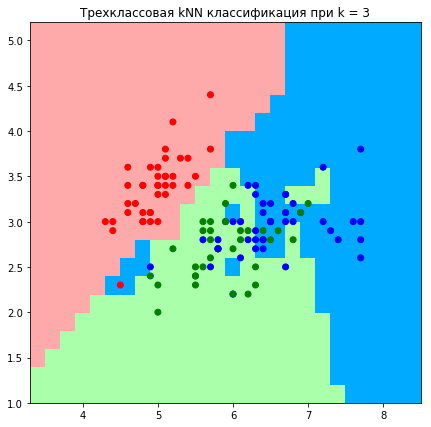

Wall time: 1.39 s


In [ ]:
%%time
get_graph(X_train, y_train, k)

In [ ]:
%%time
k = 6

y_pred = knn(X_train, y_train, X_test, k)

print(f'Точность алгоритма при k = {k}: {accuracy(y_pred, y_test):.3f}')

Точность алгоритма при k = 6: 0.833
Wall time: 61 ms


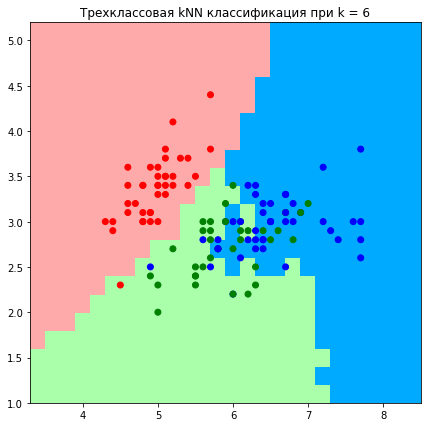

Wall time: 1.45 s


In [ ]:
%%time
get_graph(X_train, y_train, k)

In [ ]:
k = 10

y_pred = knn(X_train, y_train, X_test, k)

print(f'Точность алгоритма при k = {k}: {accuracy(y_pred, y_test):.3f}')

Точность алгоритма при k = 10: 0.833


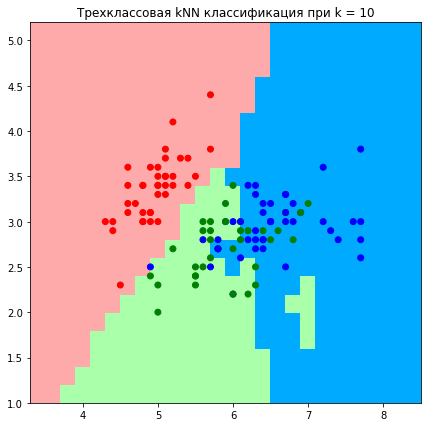

Wall time: 1.43 s


In [ ]:
%%time
get_graph(X_train, y_train, k)

При увеличении k мы на графиках наблюдаем, как алгоритм меньше концентрируется на выбросах, однако, точность на тестовой выборке при этом увеличивается.

Рассматриваемый метод, несмотря на положительные стороны в виде легкости интерпретации, простоты и удобства использования, обладает некоторыми минусами, в частности, он плохо работает на датасетах с большим количеством признаков.

Например, если мы имеем три объекта, при этом второй отличается от первого только значением одного признака, но значительно, а третий отличается от первого незначительно в каждом признаке, расстояния от первого объекта до второго и третьего могут совпадать. Несущественные различия в каждом признаке могут иметь большее значение, чем большое различие в одном признаке. Такое поведение в ряде случаев будет нежелательным. 

Второй пример - случай, когда количество признаком сравнимо с количеством объектов. В этом случае может возникнуть ситуация, когда расстояния между любыми двумя объектами почти одинаковы. В двумерном пространстве (на плоскости) три точки могут располагаться по вершинам равностороннего треугольника, при этом расстояния между ними будут равны; в трехмерном пространстве то же самое справедливо для четырех точек на вершинах тетраэдра - расстояние между любыми двумя точками будет одинаково. В общем случае это означает, что в $n$-мерном пространстве можно выбрать $n+1$ точку так, чтобы расстояние между любыми двумя точками было одинаковым.

Третий пример - так называемое "проклятие размерности". Суть его заключается в том, что при наличии $n$ бинарных признаков в пространстве признаков будет возможно $2^{n}$ различных объектов вида $x = (0,1,0,0,1,...,1)$, и размер обучающей выборки, необходимый, чтобы описать все пространство объектов (то есть все возможные комбинации таких признаков) также будет порядка $2^{n}$. Чтобы покрыть не все пространство, а долю объектов $\alpha$ (то есть долю объема $\alpha$) нужно будет описать гиперкуб с длиной ребра $e_{p} = \alpha^{n}$. Например, в 10-мерном пространстве признаков чтобы покрыть 1% объема нужно взять гиперкуб с длиной $e_{10}(0,01) = 0.63$, то есть взять окрестность длиной больше половины ребра исходного пространства. Чем больше признаков, тем меньше будет область, которая покрывается во время поиска на заданном расстоянии. Таким образом, при сохранении требований по точности нахождения объекта в пространстве, количество требуемых данных для этого при увеличении количества признаков растет экспоненциально (подробнее про это явление см. в доп. материалах).

## Литература

1. Факторный, дискриминантный и кластерный анализ: Пер. с англ./Дж.-О. Ким, Ч. У. Мьюллер, У. Р. Клекка и др.; Под ред. И. С. Енюкова. — М.: Финансы и статистика, 1989.— 215 с.
2. [Об использовании мер сходства при анализе документации](http://ceur-ws.org/Vol-803/paper18.pdf)
3. [KNN Algorithm](https://medium.com/datadriveninvestor/knn-algorithm-and-implementation-from-scratch-b9f9b739c28f)
4. [Проклятие размерности](http://www.machinelearning.ru/wiki/index.php?title=%D0%9F%D1%80%D0%BE%D0%BA%D0%BB%D1%8F%D1%82%D0%B8%D0%B5_%D1%80%D0%B0%D0%B7%D0%BC%D0%B5%D1%80%D0%BD%D0%BE%D1%81%D1%82%D0%B8); ([Иллюстрация](https://www.youtube.com/watch?v=R2hQIJb0Lis))
5. [Оценка качества кластеризации](http://neerc.ifmo.ru/wiki/index.php?title=%D0%9E%D1%86%D0%B5%D0%BD%D0%BA%D0%B0_%D0%BA%D0%B0%D1%87%D0%B5%D1%81%D1%82%D0%B2%D0%B0_%D0%B2_%D0%B7%D0%B0%D0%B4%D0%B0%D1%87%D0%B5_%D0%BA%D0%BB%D0%B0%D1%81%D1%82%D0%B5%D1%80%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D0%B8)
6. [Обзор алгоритмов кластеризации данных](https://habr.com/ru/post/101338/)
7. [Работа алгоритмов кластеризации на классах разной формы](https://scikit-learn.org/stable/modules/clustering.html)

## Summary

__kNN__
* Метрический алгоритм классификации по "ближайшим соседям"
* Разновидности: ближайший сосед, k ближайших соседей, k взвешанных ближайших соседей
* Алгоритм интерпретируем
* В основе алгоримта лежит _гипотеза компактности_: если мера сходства объектов введена достаточно удачно, то схожие объекты гораздо чаще лежат в одном классе, чем в разных
* Проблемы и их решения
    * Выбор метрики __->__ нет единого алгоритма, позволяющего выбрать метрику, поэтому используют что-то из "стандартного" (например, Евклидова)
    * Выбор числа соседей k __->__ подбор на основании кросс-валидации, чаще даже по контролю одного объекта (leave-one-out cross-validation)
    * Выбросы/шум __->__ ручной отсев, придание меньшего веса, либо поиск типичных представителей классов (эталонов) алгоритмом STOLP, тогда объект можно классифицировать по ближайшему эталону
    * Большие выборки __->__ уменьшение выборки за счет удаления неинформативных объектов (например, оставить только эталоны), либо более быстрые структуры данных (например, kd-деревья)
    * Много признаков - "проклятие размерности" - суммы большого числа отклонений по отдельным признакам с большой вероятностью имеют очень близкие значения (согласно закону больших чисел), то есть в пространстве высокой размерности все объекты примерно одинаково далеки друг от друга __->__ предварительный отбор признаков (feature selection)
